In [1]:
!pip install keras-cv keras-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 25.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

In [3]:
class_ids = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor',
    'total'
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [4]:
BATCH_SIZE = 4

In [5]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
  inputs = next(iter(inputs.take(1)))
  images, bounding_boxes = inputs['images'], inputs['bounding_boxes']
  visualization.plot_bounding_box_gallery(
      images,
      value_range = value_range,
      rows = rows,
      cols = cols,
      bounding_box_format = bounding_box_format,
      class_mapping = class_mapping,
  )

In [6]:
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
  image = inputs["image"]
  boxes = keras_cv.bounding_box.convert_format(
      inputs['objects']['bbox'],
      images = image,
      source = "rel_yxyx",
      target = bounding_box_format,
  )

  bounding_boxes = {
      "classes": tf.cast(inputs['objects']['label'], dtype=tf.float32),
      "boxes": tf.cast(boxes, dtype=tf.float32),
  }

  return {
      "images": tf.cast(image, tf.float32),
      "bounding_boxes": bounding_boxes
  }

In [7]:
def load_pascal_voc(split, dataset, bounding_box_format):
  ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
  ds = ds.map(
      lambda x: unpackage_raw_tfds_inputs(
          x,
          bounding_box_format=bounding_box_format
      ),
      num_parallel_calls = tf.data.AUTOTUNE,
  )

  return ds

In [ ]:
train_ds = load_pascal_voc(
    split= "train",
    dataset= "voc/2007",
    bounding_box_format = "xywh"
)

eval_ds = load_pascal_voc(
    split= "test",
    dataset= "voc/2007",
    bounding_box_format = "xywh"
)

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [9]:
#We use ragged batch since images can be of different sizes
#and each image can have variable number of objects

train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

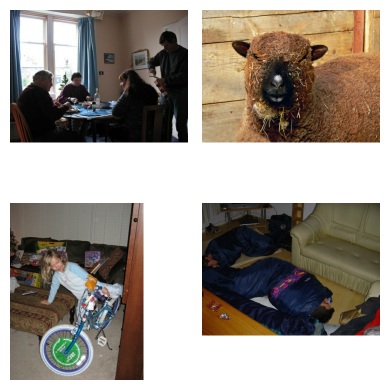

In [11]:
#Visualize the dataset to ensure bounding boxes are in the right place
#with correct labels. if done incorrectly, bounding boxes will not appear
#or they will be in the wrong place.

visualize_dataset(
    train_ds,
    bounding_box_format = "xywh",
    value_range = (0, 255),
    rows=2,
    cols=2
)

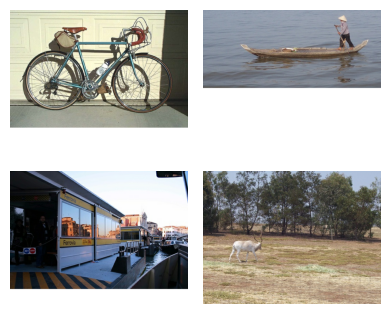

In [13]:
#Visualize the validation set
visualize_dataset(
    eval_ds,
    bounding_box_format = "xywh",
    value_range = (0, 255),
    rows=2,
    cols=2
)

In [14]:
#Data augmentation is complex since after the image is modified, the bounding
#boxes must also be modified accordingly!!

augmenter = keras.Sequential(layers=[
    keras_cv.layers.RandomFlip(
        mode= "horizontal",
        bounding_box_format = "xywh"
    ),

    keras_cv.layers.JitteredResize(
        target_size = (640, 640),
        scale_factor = (0.75, 1.3),
        bounding_box_format = "xywh"
    ),
  ]
)

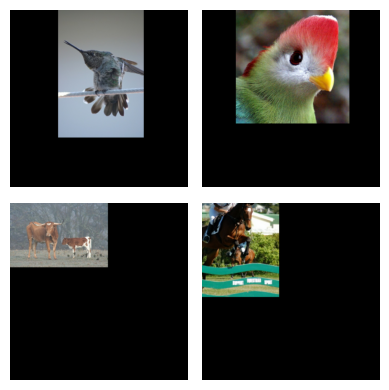

In [16]:
train_ds = train_ds.map(augmenter, num_parallel_calls = tf.data.AUTOTUNE)
visualize_dataset(
    train_ds,
    bounding_box_format = "xywh",
    value_range = (0, 255),
    rows=2,
    cols=2
)

In [17]:
#Let's use deterministic resizing for the validation set

inference_resizing = keras_cv.layers.Resizing(
    640,
    640,
    bounding_box_format = "xywh",
    pad_to_aspect_ratio = True
)

eval_ds = eval_ds.map(inference_resizing, num_parallel_calls = tf.data.AUTOTUNE)

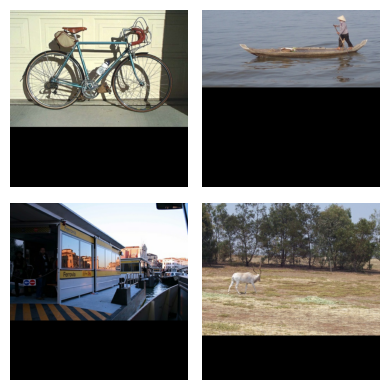

In [19]:
#Let's make sure the resizing worked!

visualize_dataset(
    eval_ds,
    bounding_box_format = "xywh",
    value_range = (0, 255),
    rows=2,
    cols=2
)

In [20]:
#This is the final form our model expects:
#Tuple of (images, bounding_box_dictionary)

def dict_to_tuple(inputs):
  return inputs['images'], bounding_box.to_dense(
      inputs['bounding_boxes'],
      max_boxes =32
  )

In [21]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

In [22]:
#Global clipnorm helps to reduce exploding gradient

base_lr = 0.005

#including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate = base_lr,
    momentum = 0.9,
    global_clipnorm = 10.0
)

In [24]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc",
    bounding_box_format = "xywh"
)

100%|██████████| 136M/136M [00:10<00:00, 13.8MB/s]


In [25]:
#Special losses in object detection
pretrained_model.compile(
    classification_loss = "focal",
    box_loss = "smoothl1"
)


In [27]:
#Creates a RetinaNet from resnet50 backbone

model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes = len(class_mapping),
    bounding_box_format = "xywh"
)


100%|██████████| 777/777 [00:00<00:00, 864kB/s]


100%|██████████| 90.3M/90.3M [00:07<00:00, 12.7MB/s]


In [28]:
model.compile(
    classification_loss = "focal",
    box_loss = "smoothl1",
    optimizer = optimizer
)

In [29]:
model.fit(
    train_ds.take(20),
    validation_data = eval_ds.take(20), #We take 20 samples from dataset splits, because training takes long time
    epochs = 10,
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - box_loss: 0.7187 - classification_loss: 1.1564 - loss: 1.8751 - val_box_loss: 0.6884 - val_classification_loss: 1.0690 - val_loss: 1.7575
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 681ms/step - box_loss: 0.6762 - classification_loss: 1.0293 - loss: 1.7055 - val_box_loss: 0.6806 - val_classification_loss: 1.0301 - val_loss: 1.7107
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 672ms/step - box_loss: 0.6564 - classification_loss: 0.9365 - loss: 1.5929 - val_box_loss: 0.6717 - val_classification_loss: 0.9170 - val_loss: 1.5887
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 656ms/step - box_loss: 0.6524 - classification_loss: 0.8362 - loss: 1.4886 - val_box_loss: 0.6668 - val_classification_loss: 0.8924 - val_loss: 1.5592
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 765ms/step - box_loss: 0.6340 - classification_loss: 0.7798 - loss: 1.4138 - val_box_loss: 0.6504 - val_classification_loss: 0.8201 - val_loss: 1.4705
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━

In [30]:
#Let's load a fully trained model to test predictions
model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc",
    bounding_box_format="xywh"
)

In [31]:
#Construct a dataset with larger batches:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [32]:
def visualize_detections(model, dataset, bounding_box_format):
  images, y_true = next(iter(dataset.take(1)))
  y_pred = model.predict(images)

  visualization.plot_bounding_box_gallery(
      images,
      value_range = (0, 255),
      bounding_box_format = bounding_box_format,
      y_true = y_true,
      y_pred = y_pred,
      scale = 4,
      rows = 4,
      cols = 2,
      show = True,
      font_scale = 0.7,
      class_mapping = class_mapping,
  )

In [34]:
#Set IoU and confidence threshold
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format = "xywh",
    from_logits = True,
    iou_threshold = 0.5,
    confidence_threshold = 0.75
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


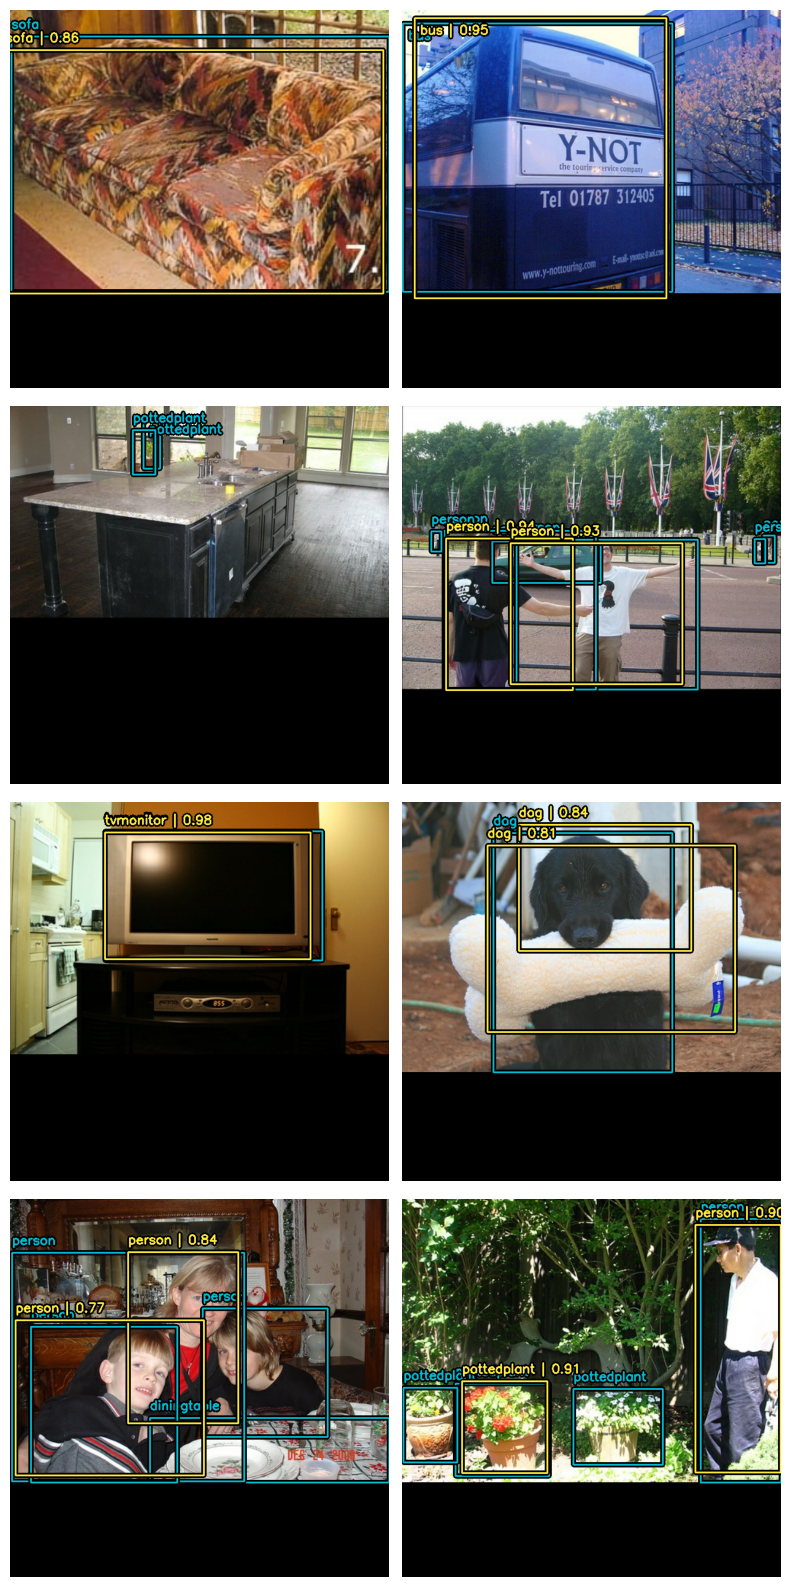

In [38]:
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")